<a href="https://colab.research.google.com/github/lmuther8/Predictive-Machine-Failure/blob/main/2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using ML to predict machinery failure

In this notebook we read in the master DataFrame and then acquire the neccessary statistics in order to fine tune a machine learning classifier model.

This model incorporates 24 hour and 3 hour lag-data statistics, total number of errors in each time period, and days since each component has had maintenance on it.

This also validates samples data to make sure it is across the same machine and consistent data over the time period.

##Configs

In [ ]:
#Connecting to G Drive
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/MyDrive/ColabNotebooks/PredictiveModelling/data/

Mounted at /gdrive
/gdrive/MyDrive/PredictiveModelling/data


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [ ]:
master_df = pd.read_csv('combined_data.csv')
master_df['datetime'] = pd.to_datetime(master_df['datetime']) #no formatting needed as it is already default style

##Create data neccessary for creating a model

###Functions to get necessary stats from TS data

In [ ]:
tel_columns = ["volt", "rotate", "pressure", "vibration"]
error_columns = ["error1", "error2", "error3", "error4", "error5"]
maint_columns = ["comp1", "comp2", "comp3", "comp4"]

In [ ]:
def validate_machine(df, lag_start, lag_length):
  if df['machineID'][lag_start-lag_length] == df['machineID'][lag_start]:
    return True
  else:
    return False

In [ ]:
def validate_datetime(df, lag_start, lag_length):
  if df['datetime'][lag_start-lag_length]+pd.Timedelta(str(lag_length)+' hours') == df['datetime'][lag_start]:
    return True
  else:
    return False

In [ ]:
def get_stats(df, lag_start, lag_length):
  lag_df = df.iloc[lag_start-lag_length:lag_start+1]
  
  if not validate_machine(lag_df, lag_start, lag_length):
    raise ValueError('This DataFrame consists of data across different machines at index {} for {} hours of lag'.format(lag_start,lag_length))
  
  if not validate_datetime(lag_df, lag_start, lag_length):
    raise ValueError('The DataFrame does not contain {} hours of continuous data at index {}'.format(lag_length, lag_start))
  
  res = []
  for c in tel_columns:
    res.extend([
                lag_df[c].min(),
                lag_df[c].max(),
                lag_df[c].std(),
                lag_df[c].mean()
    ])
  
  for c in error_columns:
    res.append(lag_df[c].sum())
  
  for c in maint_columns:
    res.append(master_df[c][lag_start+1])

  return res

###Create DataFrame consisting of all failures and the stats on the data leading up to the failure

In [ ]:
col_titles = []
for c in tel_columns:
  col_titles.append(c+'_min')
  col_titles.append(c+'_max')
  col_titles.append(c+'_std')
  col_titles.append(c+'_mean')
col_titles.extend(error_columns)
col_titles.extend(maint_columns)

lag_length_short = 3

for c in col_titles.copy():
  col_titles.append(c+'3')

In [ ]:
failure_indexes = master_df.index[master_df['failure'].notnull()]

In [ ]:
lag_length = 24
predict_ahead = 12

failures_stats = []

for f in failure_indexes:
  try:
    temp_ls = get_stats(master_df, f-predict_ahead, lag_length)
    temp_ls.extend(get_stats(master_df, f-predict_ahead, lag_length_short))
    failures_stats.append(temp_ls)
  except Exception as e:
    print(e)


This DataFrame consists of data across different machines at index 131433 for 24 hours of lag
This DataFrame consists of data across different machines at index 131434 for 24 hours of lag
This DataFrame consists of data across different machines at index 140196 for 24 hours of lag
This DataFrame consists of data across different machines at index 184004 for 24 hours of lag
This DataFrame consists of data across different machines at index 201531 for 24 hours of lag
This DataFrame consists of data across different machines at index 297905 for 24 hours of lag
This DataFrame consists of data across different machines at index 385517 for 24 hours of lag
This DataFrame consists of data across different machines at index 438084 for 24 hours of lag
This DataFrame consists of data across different machines at index 481891 for 24 hours of lag
This DataFrame consists of data across different machines at index 499414 for 24 hours of lag
This DataFrame consists of data across different machines at

In [ ]:
failures_stats_df = pd.DataFrame(failures_stats, columns = col_titles)

failures_stats_df['failure'] = True

In [ ]:
print(failures_stats_df.shape)

failures_stats_df.head()

(740, 51)


,volt_min,volt_max,volt_std,volt_mean,rotate_min,rotate_max,rotate_std,rotate_mean,pressure_min,pressure_max,...,error13,error23,error33,error43,error53,comp13,comp23,comp33,comp43,failure
0,129.016707,215.656488,18.137433,172.306548,365.213804,520.582694,41.565146,443.474698,82.400818,118.853452,...,0.0,0.0,0.0,0.0,0.0,3.541667,3.541667,3.541667,3.541667,True
1,158.476091,216.930340,15.433975,189.281258,354.540120,506.733460,47.495033,437.524998,74.378060,115.511427,...,0.0,0.0,0.0,0.0,0.0,44.541667,63.541667,14.541667,29.541667,True
2,150.503649,201.731995,13.304016,173.429452,215.619476,489.502527,61.290206,372.903177,79.552597,121.827141,...,0.0,0.0,0.0,0.0,0.0,29.541667,108.541667,14.541667,74.541667,True
3,142.165191,198.380679,15.522807,171.752624,387.342414,590.323104,44.815089,457.237727,80.630055,136.553131,...,0.0,0.0,0.0,0.0,0.0,89.541667,29.541667,14.541667,134.541667,True
4,138.740244,196.427450,13.723886,169.202447,345.711420,549.741973,46.696763,450.423297,75.959631,121.728619,...,0.0,0.0,0.0,0.0,0.0,29.541667,59.541667,89.541667,74.541667,True


###Create DataFrame with normal functioning machinery data

In [ ]:
failure_indexes_plus = []
for f in failure_indexes:
  failure_indexes_plus.extend(np.arange(f-36,f+1))


In [ ]:
normal_indexes = master_df.drop(failure_indexes_plus).sample(30000, random_state=8).index

In [ ]:
normal_stats = []

for n in normal_indexes:
  try:
    temp_ls = get_stats(master_df, n-predict_ahead, lag_length)
    temp_ls.extend(get_stats(master_df, n-predict_ahead, lag_length_short))
    normal_stats.append(temp_ls)
  except Exception as e:
    print(e)

The DataFrame does not contain 24 hours of continuous data at index 447286
The DataFrame does not contain 24 hours of continuous data at index 799915
This DataFrame consists of data across different machines at index 306660 for 24 hours of lag
The DataFrame does not contain 24 hours of continuous data at index 822559
The DataFrame does not contain 24 hours of continuous data at index 107547
This DataFrame consists of data across different machines at index 481893 for 24 hours of lag
This DataFrame consists of data across different machines at index 148963 for 24 hours of lag
This DataFrame consists of data across different machines at index 473142 for 24 hours of lag
This DataFrame consists of data across different machines at index 175252 for 24 hours of lag
The DataFrame does not contain 24 hours of continuous data at index 768075
This DataFrame consists of data across different machines at index 841095 for 24 hours of lag
This DataFrame consists of data across different machines at 

In [ ]:
normal_stats_df = pd.DataFrame(normal_stats, columns = col_titles)

normal_stats_df['failure'] = False

In [ ]:
print(normal_stats_df.shape)

(29893, 51)


###Combine DataFrames

In [ ]:
master_stats_df = pd.concat([failures_stats_df, normal_stats_df], ignore_index=True)

In [ ]:
#shuffle around DataFrame
master_stats_df = master_stats_df.sample(len(master_stats_df), random_state=8)

master_stats_df.head()

,volt_min,volt_max,volt_std,volt_mean,rotate_min,rotate_max,rotate_std,rotate_mean,pressure_min,pressure_max,...,error13,error23,error33,error43,error53,comp13,comp23,comp33,comp43,failure
23049,144.377403,176.763389,10.247694,163.455458,369.183978,522.124162,44.631546,446.221390,77.501473,118.873390,...,0.0,0.0,0.0,0.0,0.0,9.291667,99.291667,84.291667,39.291667,False
6288,141.878350,201.632637,15.495401,169.141691,379.304880,509.468594,33.733427,440.694909,91.524717,138.293561,...,0.0,0.0,0.0,0.0,0.0,60.125000,75.125000,0.125000,15.125000,False
569,167.385308,218.057248,12.877112,195.312235,379.894186,538.412519,37.953315,460.515633,84.886107,121.011716,...,0.0,0.0,0.0,0.0,0.0,44.541667,29.541667,44.541667,45.541667,True
7697,130.413218,197.852963,16.131901,165.327661,303.453623,542.124865,51.421387,446.829983,83.904587,116.958301,...,0.0,0.0,0.0,0.0,0.0,27.125000,12.125000,87.125000,87.125000,False
760,147.786259,191.609297,12.934729,168.541732,303.836524,571.925739,57.251056,440.058879,77.324460,120.202143,...,0.0,0.0,0.0,0.0,0.0,18.125000,33.125000,33.125000,3.125000,False


##Machine Learning Time

###Split data into train, validate, test

In [ ]:
np.random.seed(8)

In [ ]:
split_mask = np.random.rand(len(master_stats_df)) < 0.7

x_df = master_stats_df.drop(['failure'], axis=1)
y_df = master_stats_df['failure']

x_train = x_df[split_mask]
y_train = y_df[split_mask]

x_test_validation = x_df[~split_mask]
y_test_validation = y_df[~split_mask]

split_mask = np.random.rand(len(x_test_validation)) < 0.5
x_validation = x_test_validation[split_mask]
y_validation = y_test_validation[split_mask]

x_test = x_test_validation[~split_mask]
y_test = y_test_validation[~split_mask]

###Fine Tune

In [ ]:
fine_model = XGBClassifier(
    objective='binary:logistic',
    tree_method='gpu_hist',
    seed=8
    )

In [ ]:
parameters = {
    'max_depth': [2,4,8,12],            #depth of trees
    'n_estimators': [100,200,300,400],  #number of trees
    'learning_rate': [.08,.1,.15,.2]
}

In [ ]:
#scoring options: 'roc_auc', 'f1'

#n_jobs 1 took for 3m 27s 15 fits
#n_jobs 4 took for 3m 0s 15 fits
#n_jobs -1 took for 2m 40s 15 fits

#n_jobs -1 Fitting 192 fits took 35m 13s

grid_search = GridSearchCV(
    estimator = fine_model,
    param_grid = parameters,
    scoring = 'f1',
    n_jobs = -1,
    cv = 3,
    verbose = 1
)

In [ ]:
grid_search.fit(x_df, y_df)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3, estimator=XGBClassifier(seed=8, tree_method='gpu_hist'),
             n_jobs=-1,
             param_grid={'learning_rate': [0.08, 0.1, 0.15, 0.2],
                         'max_depth': [2, 4, 8, 12],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='f1', verbose=1)

In [ ]:
grid_search.best_params_

{'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 300}

###Create model

use logloss, aucpr, and error for eval_metrics

In [ ]:
model = XGBClassifier(
    max_depth=grid_search.best_params_['max_depth'],
    n_estimators=grid_search.best_params_['n_estimators'],
    learning_rate=grid_search.best_params_['learning_rate'],
    tree_method='gpu_hist',
    seed=0
)

model.fit(
    x_train, 
    y_train, 
    eval_set=[(x_validation, y_validation)], 
    early_stopping_rounds=10, 
    eval_metric="aucpr"
)

[0]	validation_0-aucpr:0.708548
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.739018
[2]	validation_0-aucpr:0.771629
[3]	validation_0-aucpr:0.773361
[4]	validation_0-aucpr:0.77505
[5]	validation_0-aucpr:0.780181
[6]	validation_0-aucpr:0.79967
[7]	validation_0-aucpr:0.804175
[8]	validation_0-aucpr:0.808363
[9]	validation_0-aucpr:0.797812
[10]	validation_0-aucpr:0.801124
[11]	validation_0-aucpr:0.819614
[12]	validation_0-aucpr:0.827291
[13]	validation_0-aucpr:0.836139
[14]	validation_0-aucpr:0.84426
[15]	validation_0-aucpr:0.848549
[16]	validation_0-aucpr:0.850935
[17]	validation_0-aucpr:0.854848
[18]	validation_0-aucpr:0.860372
[19]	validation_0-aucpr:0.864478
[20]	validation_0-aucpr:0.865522
[21]	validation_0-aucpr:0.869574
[22]	validation_0-aucpr:0.873047
[23]	validation_0-aucpr:0.876933
[24]	validation_0-aucpr:0.877094
[25]	validation_0-aucpr:0.876669
[26]	validation_0-aucpr:0.883993
[27]	validation_0-aucpr:0.88736
[28]	validation_0-aucpr:

XGBClassifier(learning_rate=0.08, max_depth=4, n_estimators=300, seed=0,
              tree_method='gpu_hist')

###Test model

Precision 0.9965290821658774, Recall 0.9964141640519946, F-Score 0.9964563011841415


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


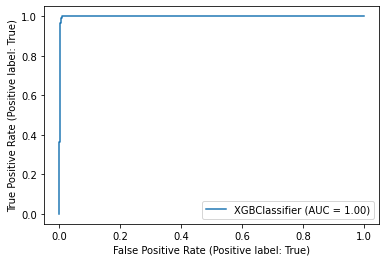

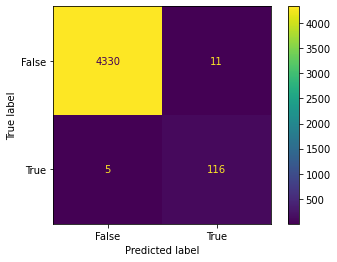

In [ ]:
test_predictions = model.predict(x_test)
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, test_predictions, average='weighted')

print("Precision {}, Recall {}, F-Score {}".format(precision, recall, fscore))
metrics.plot_roc_curve(model, x_test, y_test)
metrics.plot_confusion_matrix(model, x_test, y_test)


Precision 0.998226169981272, Recall 0.9981719061143212, F-Score 0.9981896070977352


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


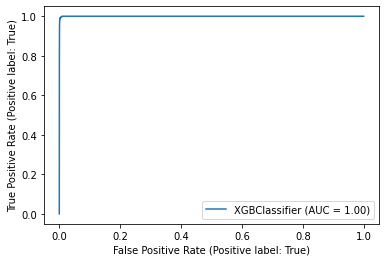

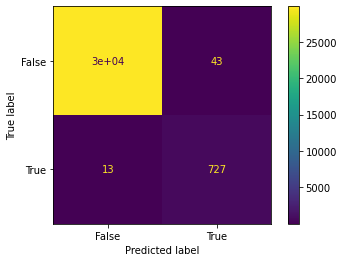

In [ ]:
test_predictions = model.predict(x_df)
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_df, test_predictions, average='weighted')

print("Precision {}, Recall {}, F-Score {}".format(precision, recall, fscore))
metrics.plot_roc_curve(model, x_df, y_df)
metrics.plot_confusion_matrix(model, x_df, y_df)

#References

Data: https://github.com/DeeptiChevvuri/Predictive-Maintenance-Modelling-Datasets

Guide: https://medium.com/@andrey.i.karpov/predictive-maintenance-on-factory-data-4f8cc17696e4

GridSearch: https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/